## Import relevant modules

In [1]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go

## Read the data

**Add authentication for Google**

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Download and read data**

In [4]:
fileDownloaded = drive.CreateFile({"id":"1o8KwQ11zVFALKAIYxgRollxMTrOq0xsj"})

In [5]:
fileDownloaded.GetContentFile("stock_data.csv")
stock_df = pd.read_csv("stock_data.csv")
stock_df

,Date,FB,TWTR,NFLX
0,2013-11-07,47.560001,44.900002,46.694286
1,2013-11-08,47.529999,41.650002,47.842857
2,2013-11-11,46.200001,42.900002,48.272858
3,2013-11-12,46.610001,41.900002,47.675713
4,2013-11-13,48.709999,42.599998,47.897144
...,...,...,...,...
1707,2020-08-20,269.010010,38.959999,497.899994
1708,2020-08-21,267.010010,39.259998,492.309998
1709,2020-08-24,271.390015,40.490002,488.809998
1710,2020-08-25,280.820007,40.549999,490.579987


##Process the data##

**Define function for plotting line chart via intereactive plot**

In [6]:
def interactive_plot(df,title):
    fig = px.line(title = title)
    for i in df.columns[1:]:
        fig.add_scatter(x = df['Date'], y = df[i], name = i)
    fig.show()

**Plot the change of stock price over time**

In [7]:
interactive_plot(stock_df,'Stock Prices Of FB, TWTR, And NFLX')

**Since the original chart is too large, I draw another one**

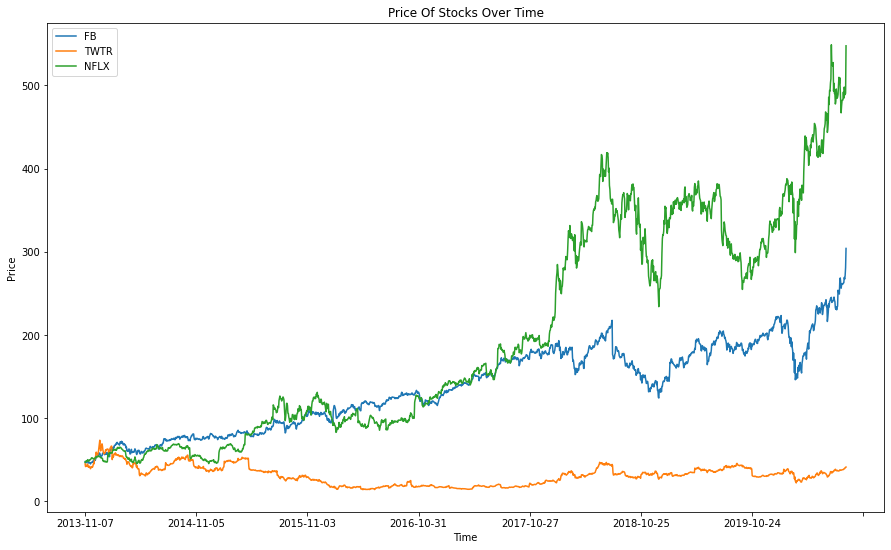

In [8]:
stock_df.plot(kind='line',x='Date',y=['FB','TWTR','NFLX'],figsize=(15,9))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title("Price Of Stocks Over Time")
plt.show()

**Normalize the price**

In [9]:
def normalize(df):  # Define the normalize function by setting initial price = 1 
    x = df.copy()
    for i in x.columns[1:]:
        x[i] = x[i]/x[i][0]
    return x 
normalized_stock_df = normalize(stock_df)  # Get the normalized price
normalized_stock_df

,Date,FB,TWTR,NFLX
0,2013-11-07,1.000000,1.000000,1.000000
1,2013-11-08,0.999369,0.927617,1.024598
2,2013-11-11,0.971405,0.955457,1.033807
3,2013-11-12,0.980025,0.933185,1.021018
4,2013-11-13,1.024180,0.948775,1.025760
...,...,...,...,...
1707,2020-08-20,5.656224,0.867706,10.662975
1708,2020-08-21,5.614172,0.874387,10.543260
1709,2020-08-24,5.706266,0.901782,10.468304
1710,2020-08-25,5.904542,0.903118,10.506210


##Formulate portfolios##

**Set random portfolio based on results from Excel (Assume there is no rebalance of portfolios)**

In [10]:
A = np.array([14,95,19])
B = np.array([48,89,53])
C = np.array([68,50,16])
D = np.array([82,11,99])
E = np.array([32,72,13])
random_list = [A,B,C,D,E]
portfolio_set = []
for i in random_list:
  portfolio_set.append(i/sum(i))
portfolio_set

[array([0.109375 , 0.7421875, 0.1484375]),
 array([0.25263158, 0.46842105, 0.27894737]),
 array([0.50746269, 0.37313433, 0.11940299]),
 array([0.42708333, 0.05729167, 0.515625  ]),
 array([0.27350427, 0.61538462, 0.11111111])]

In [11]:
portfolio_set_dict = {}
for i in range(0,len(portfolio_set)):
  portfolio_set_dict['Portfolio {}'.format(chr(65+i))] = portfolio_set[i]
portfolio_set_dict 

{'Portfolio A': array([0.109375 , 0.7421875, 0.1484375]),
 'Portfolio B': array([0.25263158, 0.46842105, 0.27894737]),
 'Portfolio C': array([0.50746269, 0.37313433, 0.11940299]),
 'Portfolio D': array([0.42708333, 0.05729167, 0.515625  ]),
 'Portfolio E': array([0.27350427, 0.61538462, 0.11111111])}

**Set empty DataFrame for the worth of portfolios**

In [12]:
daily_worth_table = pd.DataFrame(columns=['Date','Portfolio A',"Portfolio B",'Portfolio C','Portfolio D', 'Portfolio E'])
daily_worth_table['Date'] = normalized_stock_df['Date']
daily_worth_table

,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E
0,2013-11-07,NaN,NaN,NaN,NaN,NaN
1,2013-11-08,NaN,NaN,NaN,NaN,NaN
2,2013-11-11,NaN,NaN,NaN,NaN,NaN
3,2013-11-12,NaN,NaN,NaN,NaN,NaN
4,2013-11-13,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1707,2020-08-20,NaN,NaN,NaN,NaN,NaN
1708,2020-08-21,NaN,NaN,NaN,NaN,NaN
1709,2020-08-24,NaN,NaN,NaN,NaN,NaN
1710,2020-08-25,NaN,NaN,NaN,NaN,NaN


##Assess the portfolios##

**Compute the worth of portfolio, assuming that we have 1 million dollar and portfolio are not rebalanced over time**

In [13]:
for i in range(1,daily_worth_table.shape[1]):
  for j in range(0,daily_worth_table.shape[0]):  # total worth = percentage in stock A * normalized price in stock A + percentage in stock B * normalized price in stock B + percentage in stock C * normalized price in stock C...
     daily_worth_table.iloc[j,i] = 1000000 * (portfolio_set[i-1][0]*normalized_stock_df['FB'][j]+portfolio_set[i-1][1]*normalized_stock_df['TWTR'][j]+portfolio_set[i-1][2]*normalized_stock_df['NFLX'][j])
daily_worth_table  


,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E
0,2013-11-07,1e+06,1e+06,1e+06,1e+06,1e+06
1,2013-11-08,949860,972796,975608,1.00827e+06,958017
2,2013-11-11,968831,981341,972905,1.00267e+06,968524
3,2013-11-12,951346,969519,967442,998479,955755
4,2013-11-13,968450,989299,996232,1.02067e+06,977952
...,...,...,...,...,...,...
1707,2020-08-20,2.84544e+06,4.8098e+06,4.46728e+06,7.96349e+06,3.26575e+06
1708,2020-08-21,2.82802e+06,4.76891e+06,4.43414e+06,7.88418e+06,3.24506e+06
1709,2020-08-24,2.8473e+06,4.7841e+06,4.48215e+06,7.88644e+06,3.27878e+06
1710,2020-08-25,2.87561e+06,4.84539e+06,4.58779e+06,7.99074e+06,3.33804e+06


**Plot the worth of portfolios**

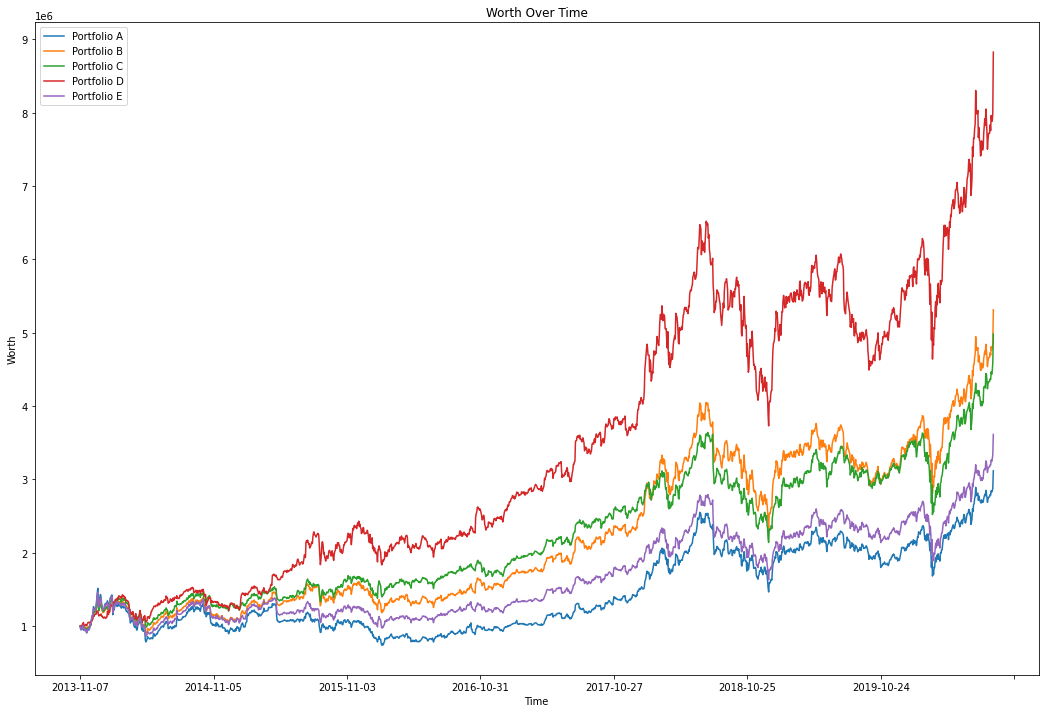

In [14]:
daily_worth_table.plot.line(x='Date',y=['Portfolio A','Portfolio B','Portfolio C','Portfolio D','Portfolio E'],stacked=False, figsize=(18,12))
plt.xlabel('Time')
plt.ylabel('Worth')
plt.title('Worth Over Time')
plt.show()

**Set an empty table for the return of portfolios**

In [15]:
daily_return_table = pd.DataFrame(columns=['Date','Portfolio A',"Portfolio B",'Portfolio C','Portfolio D', 'Portfolio E'])
daily_return_table['Date'] = normalized_stock_df['Date']
daily_return_table.drop([0,0],axis=0, inplace=True)  # We don't need the return at the first day
daily_return_table.reset_index(drop=True,inplace=True)
daily_return_table

,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E
0,2013-11-08,NaN,NaN,NaN,NaN,NaN
1,2013-11-11,NaN,NaN,NaN,NaN,NaN
2,2013-11-12,NaN,NaN,NaN,NaN,NaN
3,2013-11-13,NaN,NaN,NaN,NaN,NaN
4,2013-11-14,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1706,2020-08-20,NaN,NaN,NaN,NaN,NaN
1707,2020-08-21,NaN,NaN,NaN,NaN,NaN
1708,2020-08-24,NaN,NaN,NaN,NaN,NaN
1709,2020-08-25,NaN,NaN,NaN,NaN,NaN


**Compute the returns of portfolios**

In [16]:
for i in range(1,daily_return_table.shape[1]):
  for j in range(0,daily_return_table.shape[0]):
     daily_return_table.iloc[j,i] = daily_worth_table.iloc[j+1,i]/daily_worth_table.iloc[j,i]-1
daily_return_table

,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E
0,2013-11-08,-0.0501396,-0.0272037,-0.0243917,0.00826682,-0.0419829
1,2013-11-11,0.0199719,0.00878366,-0.00277111,-0.00555402,0.0109673
2,2013-11-12,-0.0180477,-0.0120468,-0.00561477,-0.00417711,-0.0131838
3,2013-11-13,0.0179789,0.0204023,0.0297592,0.0222299,0.0232249
4,2013-11-14,0.0397561,0.029832,0.0231064,0.0163434,0.0334712
...,...,...,...,...,...,...
1706,2020-08-20,0.0209628,0.0244305,0.0236644,0.0264729,0.0218061
1707,2020-08-21,-0.00611882,-0.00850099,-0.00741862,-0.00995856,-0.00633588
1708,2020-08-24,0.00681688,0.00318507,0.0108265,0.000285687,0.0103905
1709,2020-08-25,0.00994092,0.0128113,0.0235695,0.0132255,0.0180748


In [17]:
interactive_plot(daily_return_table,"Daily Return Over Time")

**Add the daily returns of these individual stocks**

In [18]:
daily_return_table['FB'] = np.nan
daily_return_table['TWTR'] = np.nan
daily_return_table['NFLX'] = np.nan
for i in range (0,daily_return_table.shape[0]):  # Daily Return = Today's Close Price / Yesterday's Close Price - 1
  daily_return_table['FB'][i] = stock_df['FB'][i+1]/stock_df['FB'][i]-1
  daily_return_table['TWTR'][i] = stock_df['TWTR'][i+1]/stock_df['TWTR'][i]-1
  daily_return_table['NFLX'][i] = stock_df['NFLX'][i+1]/stock_df['NFLX'][i]-1
daily_return_table 

,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
0,2013-11-08,-0.0501396,-0.0272037,-0.0243917,0.00826682,-0.0419829,-0.000631,-0.072383,0.024598
1,2013-11-11,0.0199719,0.00878366,-0.00277111,-0.00555402,0.0109673,-0.027982,0.030012,0.008988
2,2013-11-12,-0.0180477,-0.0120468,-0.00561477,-0.00417711,-0.0131838,0.008874,-0.023310,-0.012370
3,2013-11-13,0.0179789,0.0204023,0.0297592,0.0222299,0.0232249,0.045055,0.016706,0.004645
4,2013-11-14,0.0397561,0.029832,0.0231064,0.0163434,0.0334712,0.005748,0.049061,0.021743
...,...,...,...,...,...,...,...,...,...
1706,2020-08-20,0.0209628,0.0244305,0.0236644,0.0264729,0.0218061,0.024449,0.001800,0.027594
1707,2020-08-21,-0.00611882,-0.00850099,-0.00741862,-0.00995856,-0.00633588,-0.007435,0.007700,-0.011227
1708,2020-08-24,0.00681688,0.00318507,0.0108265,0.000285687,0.0103905,0.016404,0.031330,-0.007109
1709,2020-08-25,0.00994092,0.0128113,0.0235695,0.0132255,0.0180748,0.034747,0.001482,0.003621


In [19]:
daily_return_table.dtypes

Date            object
Portfolio A     object
Portfolio B     object
Portfolio C     object
Portfolio D     object
Portfolio E     object
FB             float64
TWTR           float64
NFLX           float64
dtype: object

**Change numerical value from object to float**

In [20]:
daily_return_table['Portfolio A'] = daily_return_table['Portfolio A'].astype(float)
daily_return_table['Portfolio B'] = daily_return_table['Portfolio B'].astype(float)
daily_return_table['Portfolio C'] = daily_return_table['Portfolio C'].astype(float)
daily_return_table['Portfolio D'] = daily_return_table['Portfolio D'].astype(float)
daily_return_table['Portfolio E'] = daily_return_table['Portfolio E'].astype(float)
daily_return_table.dtypes

Date            object
Portfolio A    float64
Portfolio B    float64
Portfolio C    float64
Portfolio D    float64
Portfolio E    float64
FB             float64
TWTR           float64
NFLX           float64
dtype: object

**Plot the historgrams of returns**

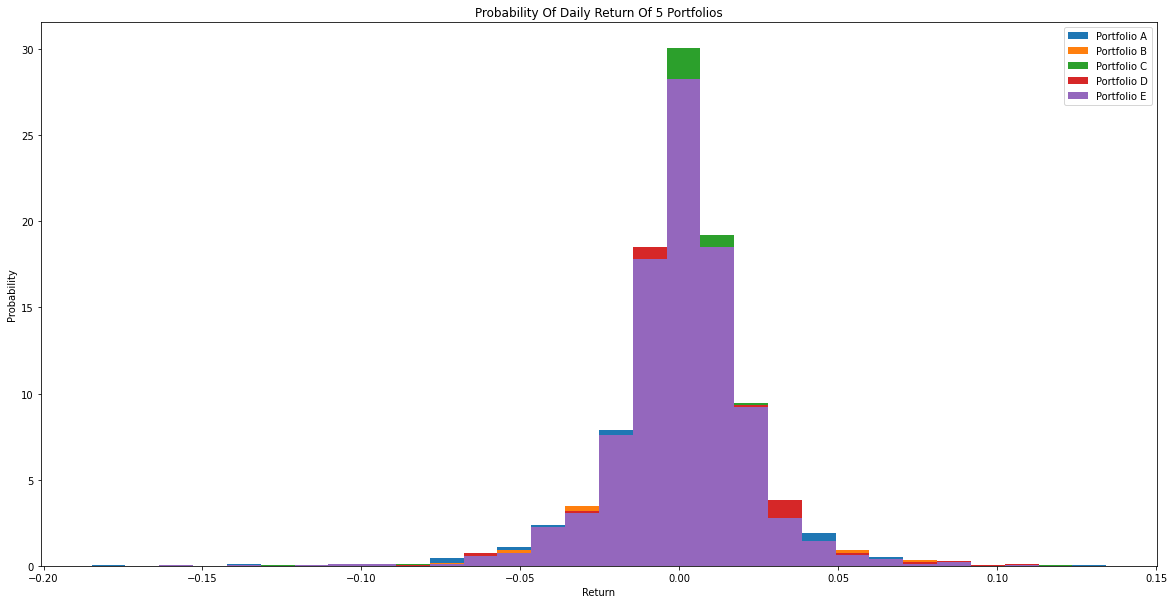

In [21]:
daily_return_table[['Portfolio A','Portfolio B','Portfolio C','Portfolio D','Portfolio E']].plot(kind = "hist", density=True, bins=30, stacked=False, figsize=(20,10))  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Return')
plt.title("Probability Of Daily Return Of 5 Portfolios")
plt.show()

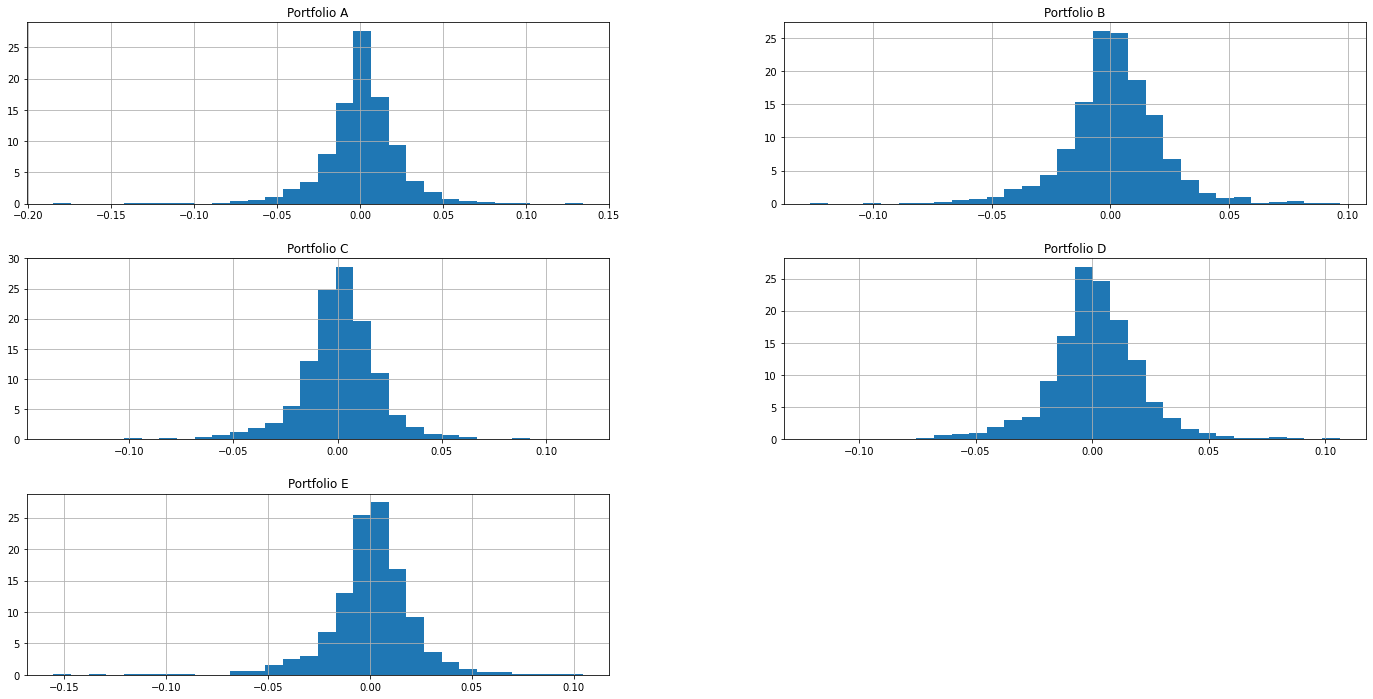

In [22]:
daily_return_table.hist(column=['Portfolio A','Portfolio B','Portfolio C','Portfolio D','Portfolio E'], density=True, bins=30, figsize=(24,12))
plt.show()

**Get the return statistics**

In [23]:
daily_return_table_new = daily_return_table.copy()
daily_return_table_new.drop(['Date'],axis=1)
return_stats = daily_return_table_new.describe()
return_stats

,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
count,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000
mean,0.000929,0.001190,0.001124,0.001483,0.000966,0.001292,0.000540,0.001790
std,0.022853,0.020615,0.019184,0.020474,0.020620,0.020344,0.034131,0.026562
min,-0.184856,-0.126580,-0.136419,-0.120887,-0.155405,-0.189609,-0.241625,-0.193696
25%,-0.009053,-0.008345,-0.007601,-0.008252,-0.007855,-0.007929,-0.014370,-0.011224
50%,0.001521,0.001336,0.001546,0.001242,0.001583,0.001248,0.000878,0.000459
75%,0.012227,0.012240,0.011192,0.012041,0.011184,0.011293,0.015060,0.014718
max,0.134243,0.096668,0.117617,0.106236,0.104534,0.155214,0.214171,0.190281


**Select returns that are below the mean**

In [24]:
return_below_mean_table = pd.DataFrame(columns=daily_return_table.columns)
return_below_mean_table['Date'] = daily_return_table['Date']
for i in range(0,return_below_mean_table.shape[0]):
  for j in range(1,return_below_mean_table.shape[1]):
    if daily_return_table.iloc[i,j] < daily_return_table.iloc[:,j].mean():
      return_below_mean_table.iloc[i,j] = daily_return_table.iloc[i,j]
    else:
      pass

return_below_mean_table

,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
0,2013-11-08,-0.0501396,-0.0272037,-0.0243917,NaN,-0.0419829,-0.000630824,-0.0723831,NaN
1,2013-11-11,NaN,NaN,-0.00277111,-0.00555402,NaN,-0.0279823,NaN,NaN
2,2013-11-12,-0.0180477,-0.0120468,-0.00561477,-0.00417711,-0.0131838,NaN,-0.02331,-0.0123702
3,2013-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1706,2020-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1707,2020-08-21,-0.00611882,-0.00850099,-0.00741862,-0.00995856,-0.00633588,-0.00743467,NaN,-0.0112271
1708,2020-08-24,NaN,NaN,NaN,0.000285687,NaN,NaN,NaN,-0.00710934
1709,2020-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Convert string to number**

In [25]:
return_below_mean_table_copy = return_below_mean_table.copy()
return_below_mean_table_copy.drop(columns=['Date'], inplace=True)
return_below_mean_table_copy.dtypes

Portfolio A    object
Portfolio B    object
Portfolio C    object
Portfolio D    object
Portfolio E    object
FB             object
TWTR           object
NFLX           object
dtype: object

In [26]:
return_below_mean_table_copy['Portfolio A'] = return_below_mean_table_copy['Portfolio A'].astype(float)
return_below_mean_table_copy['Portfolio B'] = return_below_mean_table_copy['Portfolio B'].astype(float)
return_below_mean_table_copy['Portfolio C'] = return_below_mean_table_copy['Portfolio C'].astype(float)
return_below_mean_table_copy['Portfolio D'] = return_below_mean_table_copy['Portfolio D'].astype(float)
return_below_mean_table_copy['Portfolio E'] = return_below_mean_table_copy['Portfolio E'].astype(float)
return_below_mean_table_copy['FB'] = return_below_mean_table_copy['FB'].astype(float)
return_below_mean_table_copy['TWTR'] = return_below_mean_table_copy['TWTR'].astype(float)
return_below_mean_table_copy['NFLX'] = return_below_mean_table_copy['NFLX'].astype(float)
return_below_mean_table_copy.dtypes

Portfolio A    float64
Portfolio B    float64
Portfolio C    float64
Portfolio D    float64
Portfolio E    float64
FB             float64
TWTR           float64
NFLX           float64
dtype: object

In [27]:
return_below_mean_stats = return_below_mean_table_copy.describe()
return_below_mean_stats

,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
count,825.000000,849.000000,831.000000,867.000000,824.000000,859.000000,845.000000,909.000000
mean,-0.015266,-0.013435,-0.012505,-0.012703,-0.013716,-0.012204,-0.021905,-0.015136
std,0.018280,0.015584,0.015012,0.014675,0.016561,0.015345,0.027281,0.017886
min,-0.184856,-0.126580,-0.136419,-0.120887,-0.155405,-0.189609,-0.241625,-0.193696
25%,-0.020477,-0.018712,-0.016655,-0.016853,-0.018262,-0.016454,-0.026762,-0.019732
50%,-0.009561,-0.008465,-0.007912,-0.008108,-0.008294,-0.007847,-0.014595,-0.010406
75%,-0.003491,-0.003335,-0.002835,-0.002956,-0.003264,-0.002625,-0.006377,-0.003812
max,0.000928,0.001125,0.001123,0.001478,0.000943,0.001286,0.000515,0.001789


**Compute performance assessment in several aspects, assume risk free return is 0%**

In [28]:
performance_table = pd.DataFrame(columns=return_stats.columns)
performance_table['Portfolio A'] = np.array([1,1,1,1,1,1,1])
performance_table

,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
for i in range(0,return_stats.shape[1]):
  performance_table.iloc[0,i] = return_stats.iloc[1,i]
  performance_table.iloc[1,i] = return_stats.iloc[2,i]
  performance_table.iloc[2,i] = return_stats.iloc[1,i]/return_stats.iloc[2,i]  # Compute Sharpe Ratio, which = (Expected Return - Risk Free Return) / Volatility
  performance_table.iloc[3,i] = return_stats.iloc[1,i]/return_below_mean_stats.iloc[2,i]  # Compute Sortino Ratio, which = (Expected Return - Risk Free Return) / Volatility Of Return Below Mean
  performance_table.iloc[4,i] = return_stats.iloc[1,i]-return_stats.iloc[2,i]  # Compute lowest retun in 68% of time, which = Expected Return - Volatility
  performance_table.iloc[5,i] = return_stats.iloc[1,i]+return_stats.iloc[2,i]  # Compute highest retun in 68% of time, which = Expected Return + Volatility
  performance_table.iloc[6,i] = return_stats.iloc[1,i]-1.65*return_stats.iloc[2,i]  # Compute Value at Risk (95%), which = Expected Return - 1.65 * Volatility
performance_table.rename(index={0:"Expected Return", 1:"Volatility", 2:"Sharpe Ratio",3:"Sortino Ratio",4:"Lowest Expected Return during 68% Of The Time", 5:"Highest Expected Return during 68% Of The Time",6:"Value at Risk (95%)"},inplace=True) 
performance_table


,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
Expected Return,0.000929,0.00119018,0.00112432,0.00148322,0.000965825,0.00129216,0.000540137,0.0017897
Volatility,0.022853,0.0206149,0.019184,0.0204743,0.02062,0.0203436,0.034131,0.0265619
Sharpe Ratio,0.040651,0.0577341,0.0586074,0.0724433,0.0468391,0.063517,0.0158254,0.0673782
Sortino Ratio,0.050819,0.0763717,0.0748969,0.101069,0.0583182,0.0842078,0.0197993,0.10006
Lowest Expected Return during 68% Of The Time,-0.021924,-0.0194248,-0.0180596,-0.018991,-0.0196542,-0.0190514,-0.0335909,-0.0247722
Highest Expected Return during 68% Of The Time,0.023782,0.0218051,0.0203083,0.0219575,0.0215859,0.0216357,0.0346711,0.0283516
Value at Risk (95%),-0.036778,-0.0328245,-0.0305292,-0.0322993,-0.0330572,-0.0322747,-0.055776,-0.0420375


**Make the performance table in percentage format, then plot the bar chart**

In [30]:
performance_table_in_percentage=performance_table.copy()
for i in range(0,performance_table.shape[0]):
  for j in range(0,performance_table.shape[1]):
    performance_table_in_percentage.iloc[i,j] = performance_table.iloc[i,j]*100
performance_table_in_percentage.reset_index(drop=True,inplace=True)
for k in range(0,performance_table_in_percentage.shape[1]-1):
  performance_table_in_percentage.rename(index={k:performance_table.index[k] + " in %"},inplace=True) # add " in %" into index
performance_table_in_percentage  


,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
Expected Return in %,0.092899,0.119018,0.112432,0.148322,0.0965825,0.129216,0.0540137,0.17897
Volatility in %,2.285282,2.06149,1.9184,2.04743,2.062,2.03436,3.4131,2.65619
Sharpe Ratio in %,4.065086,5.77341,5.86074,7.24433,4.68391,6.3517,1.58254,6.73782
Sortino Ratio in %,5.081896,7.63717,7.48969,10.1069,5.83182,8.42078,1.97993,10.006
Lowest Expected Return during 68% Of The Time in %,-2.192383,-1.94248,-1.80596,-1.8991,-1.96542,-1.90514,-3.35909,-2.47722
Highest Expected Return during 68% Of The Time in %,2.378180,2.18051,2.03083,2.19575,2.15859,2.16357,3.46711,2.83516
Value at Risk (95%) in %,-3.677816,-3.28245,-3.05292,-3.22993,-3.30572,-3.22747,-5.5776,-4.20375


In [31]:
performance_table_in_percentage['Performance Assessment'] = performance_table_in_percentage.index  # Set index as column
performance_table_in_percentage = performance_table_in_percentage[['Performance Assessment','Portfolio A','Portfolio B', 'Portfolio C', 'Portfolio D', 'Portfolio E', 'FB', 'TWTR', 'NFLX']]  #Rearrange the table
performance_table_in_percentage.reset_index(drop=True,inplace=True)  # Reset the index to avoid repetition
performance_table_in_percentage

,Performance Assessment,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,FB,TWTR,NFLX
0,Expected Return in %,0.092899,0.119018,0.112432,0.148322,0.0965825,0.129216,0.0540137,0.17897
1,Volatility in %,2.285282,2.06149,1.9184,2.04743,2.062,2.03436,3.4131,2.65619
2,Sharpe Ratio in %,4.065086,5.77341,5.86074,7.24433,4.68391,6.3517,1.58254,6.73782
3,Sortino Ratio in %,5.081896,7.63717,7.48969,10.1069,5.83182,8.42078,1.97993,10.006
4,Lowest Expected Return during 68% Of The Time ...,-2.192383,-1.94248,-1.80596,-1.8991,-1.96542,-1.90514,-3.35909,-2.47722
5,Highest Expected Return during 68% Of The Time...,2.378180,2.18051,2.03083,2.19575,2.15859,2.16357,3.46711,2.83516
6,Value at Risk (95%) in %,-3.677816,-3.28245,-3.05292,-3.22993,-3.30572,-3.22747,-5.5776,-4.20375


**Plot the bar chart for the above table**

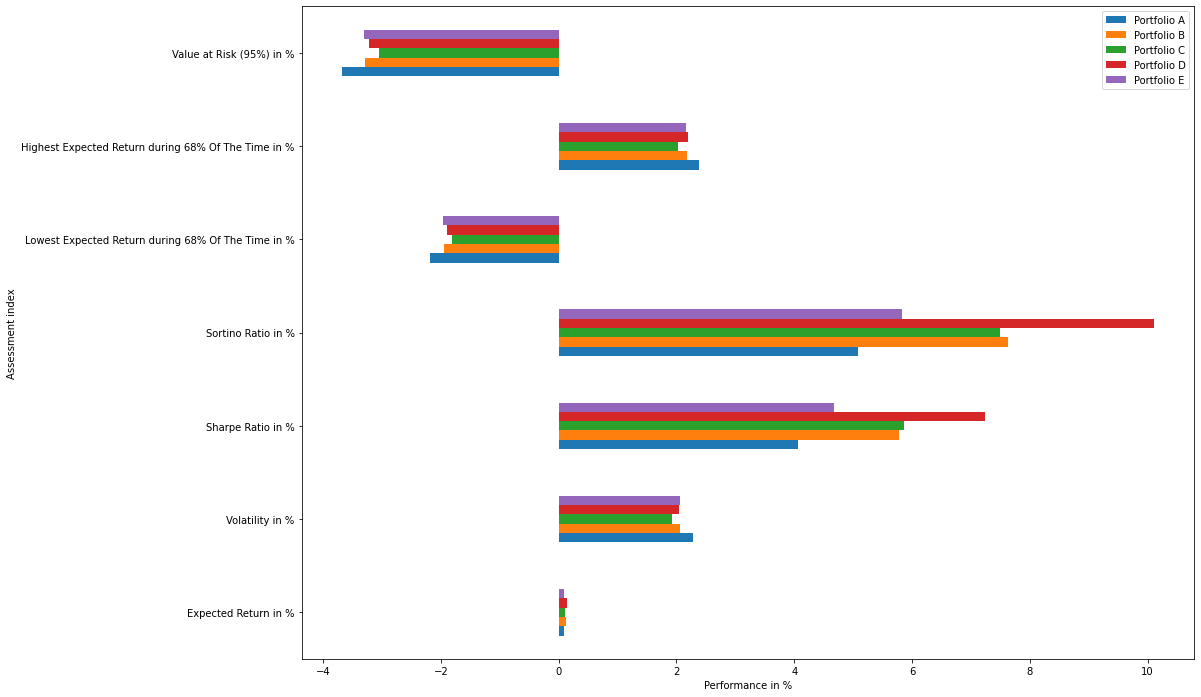

In [32]:
performance_table_in_percentage.plot(kind='barh',x='Performance Assessment',y=['Portfolio A','Portfolio B','Portfolio C', 'Portfolio D', 'Portfolio E'],figsize=(16,12))
plt.xlabel("Performance in %")
plt.ylabel("Assessment index")
plt.show()


**Check types of columns and convert string to number**

In [33]:
daily_worth_table.dtypes

Date           object
Portfolio A    object
Portfolio B    object
Portfolio C    object
Portfolio D    object
Portfolio E    object
dtype: object

In [34]:
daily_worth_table_copy = daily_worth_table.copy()
daily_worth_table_copy.dtypes

Date           object
Portfolio A    object
Portfolio B    object
Portfolio C    object
Portfolio D    object
Portfolio E    object
dtype: object

In [35]:
daily_worth_table_copy['Date'] = pd.to_datetime(daily_worth_table_copy['Date'])
daily_worth_table_copy['Portfolio A'] = daily_worth_table_copy['Portfolio A'].astype(float)
daily_worth_table_copy['Portfolio B'] = daily_worth_table_copy['Portfolio B'].astype(float)
daily_worth_table_copy['Portfolio C'] = daily_worth_table_copy['Portfolio C'].astype(float)
daily_worth_table_copy['Portfolio D'] = daily_worth_table_copy['Portfolio D'].astype(float)
daily_worth_table_copy['Portfolio E'] = daily_worth_table_copy['Portfolio E'].astype(float)
daily_worth_table_copy

,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E
0,2013-11-07,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2013-11-08,9.498604e+05,9.727963e+05,9.756083e+05,1.008267e+06,9.580171e+05
2,2013-11-11,9.688310e+05,9.813410e+05,9.729048e+05,1.002667e+06,9.685240e+05
3,2013-11-12,9.513458e+05,9.695191e+05,9.674422e+05,9.984786e+05,9.557552e+05
4,2013-11-13,9.684499e+05,9.892995e+05,9.962325e+05,1.020675e+06,9.779525e+05
...,...,...,...,...,...,...
1707,2020-08-20,2.845435e+06,4.809801e+06,4.467284e+06,7.963488e+06,3.265749e+06
1708,2020-08-21,2.828025e+06,4.768913e+06,4.434143e+06,7.884183e+06,3.245058e+06
1709,2020-08-24,2.847303e+06,4.784102e+06,4.482150e+06,7.886435e+06,3.278776e+06
1710,2020-08-25,2.875608e+06,4.845393e+06,4.587792e+06,7.990737e+06,3.338039e+06


In [36]:
daily_worth_table_copy['Number Of Days Since The First Day'] = np.nan  # Add a new empty column
daily_worth_table_copy

,Date,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E,Number Of Days Since The First Day
0,2013-11-07,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,NaN
1,2013-11-08,9.498604e+05,9.727963e+05,9.756083e+05,1.008267e+06,9.580171e+05,NaN
2,2013-11-11,9.688310e+05,9.813410e+05,9.729048e+05,1.002667e+06,9.685240e+05,NaN
3,2013-11-12,9.513458e+05,9.695191e+05,9.674422e+05,9.984786e+05,9.557552e+05,NaN
4,2013-11-13,9.684499e+05,9.892995e+05,9.962325e+05,1.020675e+06,9.779525e+05,NaN
...,...,...,...,...,...,...,...
1707,2020-08-20,2.845435e+06,4.809801e+06,4.467284e+06,7.963488e+06,3.265749e+06,NaN
1708,2020-08-21,2.828025e+06,4.768913e+06,4.434143e+06,7.884183e+06,3.245058e+06,NaN
1709,2020-08-24,2.847303e+06,4.784102e+06,4.482150e+06,7.886435e+06,3.278776e+06,NaN
1710,2020-08-25,2.875608e+06,4.845393e+06,4.587792e+06,7.990737e+06,3.338039e+06,NaN


In [37]:
daily_worth_table_copy = daily_worth_table_copy[['Date','Number Of Days Since The First Day','Portfolio A','Portfolio B', 'Portfolio C', 'Portfolio D', 'Portfolio E']]  # Rearrange the table
daily_worth_table_copy

,Date,Number Of Days Since The First Day,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E
0,2013-11-07,NaN,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2013-11-08,NaN,9.498604e+05,9.727963e+05,9.756083e+05,1.008267e+06,9.580171e+05
2,2013-11-11,NaN,9.688310e+05,9.813410e+05,9.729048e+05,1.002667e+06,9.685240e+05
3,2013-11-12,NaN,9.513458e+05,9.695191e+05,9.674422e+05,9.984786e+05,9.557552e+05
4,2013-11-13,NaN,9.684499e+05,9.892995e+05,9.962325e+05,1.020675e+06,9.779525e+05
...,...,...,...,...,...,...,...
1707,2020-08-20,NaN,2.845435e+06,4.809801e+06,4.467284e+06,7.963488e+06,3.265749e+06
1708,2020-08-21,NaN,2.828025e+06,4.768913e+06,4.434143e+06,7.884183e+06,3.245058e+06
1709,2020-08-24,NaN,2.847303e+06,4.784102e+06,4.482150e+06,7.886435e+06,3.278776e+06
1710,2020-08-25,NaN,2.875608e+06,4.845393e+06,4.587792e+06,7.990737e+06,3.338039e+06


##Convert dates to number, after which machine learning is deployed to predict performance of portfolios##

In [38]:
daily_worth_table_copy['Number Of Days Since The First Day'][0] = 0
for i in range(1,len(daily_worth_table_copy)):
  daily_worth_table_copy['Number Of Days Since The First Day'][i] = daily_worth_table_copy['Number Of Days Since The First Day'][i-1]+(daily_worth_table_copy['Date'][i]-daily_worth_table_copy['Date'][i-1]).days
daily_worth_table_copy

,Date,Number Of Days Since The First Day,Portfolio A,Portfolio B,Portfolio C,Portfolio D,Portfolio E
0,2013-11-07,0.0,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2013-11-08,1.0,9.498604e+05,9.727963e+05,9.756083e+05,1.008267e+06,9.580171e+05
2,2013-11-11,4.0,9.688310e+05,9.813410e+05,9.729048e+05,1.002667e+06,9.685240e+05
3,2013-11-12,5.0,9.513458e+05,9.695191e+05,9.674422e+05,9.984786e+05,9.557552e+05
4,2013-11-13,6.0,9.684499e+05,9.892995e+05,9.962325e+05,1.020675e+06,9.779525e+05
...,...,...,...,...,...,...,...
1707,2020-08-20,2478.0,2.845435e+06,4.809801e+06,4.467284e+06,7.963488e+06,3.265749e+06
1708,2020-08-21,2479.0,2.828025e+06,4.768913e+06,4.434143e+06,7.884183e+06,3.245058e+06
1709,2020-08-24,2482.0,2.847303e+06,4.784102e+06,4.482150e+06,7.886435e+06,3.278776e+06
1710,2020-08-25,2483.0,2.875608e+06,4.845393e+06,4.587792e+06,7.990737e+06,3.338039e+06


**Verify that all numerical values are in float**

In [39]:
daily_worth_table_copy.dtypes

Date                                  datetime64[ns]
Number Of Days Since The First Day           float64
Portfolio A                                  float64
Portfolio B                                  float64
Portfolio C                                  float64
Portfolio D                                  float64
Portfolio E                                  float64
dtype: object

**Import machine learning modules**

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [41]:
msk = np.random.rand(len(daily_worth_table_copy))<0.8
train = daily_worth_table_copy[msk]
test = daily_worth_table_copy[~msk]

**Fit the cubic polynomial for Portfolio A, but you can change the degree as you wish**

In [42]:
train_x = np.asanyarray(train[['Number Of Days Since The First Day']])
train_y = np.asanyarray(train[['Portfolio A']])
test_x = np.asanyarray(test[['Number Of Days Since The First Day']])
test_y = np.asanyarray(test[['Portfolio A']])
poly = PolynomialFeatures(degree=3)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 4.00000000e+00, 1.60000000e+01, 6.40000000e+01],
       ...,
       [1.00000000e+00, 2.48200000e+03, 6.16032400e+06, 1.52899242e+10],
       [1.00000000e+00, 2.48300000e+03, 6.16528900e+06, 1.53084126e+10],
       [1.00000000e+00, 2.48400000e+03, 6.17025600e+06, 1.53269159e+10]])

In [43]:
clf=linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly,train_y)
# The coefficients
print('Coefficients For Portfolio A: ',clf.coef_)
print('Intercept For Portfolio A: ',clf.intercept_)

Coefficients For Portfolio A:  [[ 0.00000000e+00 -1.58219414e+03  1.59643775e+00 -3.15437182e-04]]
Intercept For Portfolio A:  [1349195.78107343]


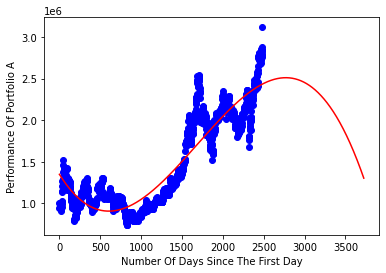

In [44]:
plt.scatter(train['Number Of Days Since The First Day'],train['Portfolio A'],color='blue')
XX = np.arange(0.0,3726,1)  # There are 2484 days in the period (2013-2020) that I analyzed. 2484*(1+50%)=3726 Thus, here is the anticipation of the performance of extra half of the period. 
yy = clf.intercept_[0]+clf.coef_[0][1]*XX+clf.coef_[0][2]*np.power(XX,2)+clf.coef_[0][3]*np.power(XX,3)
plt.plot(XX,yy,'-r')
plt.xlabel("Number Of Days Since The First Day")
plt.ylabel("Performance Of Portfolio A")
plt.show()

**Evaluate the performance of machine learning for Portfolio A**

In [45]:
from sklearn.metrics import r2_score
test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)
print("R2-score for Portfolio A is {}".format(r2_score(test_y,test_y_)))

R2-score for Portfolio A is 0.8314775385130806


**Use "for" loop to repeat the previous process for Portfolio B-E**

Coefficients for Portfolio B are [[ 0.00000000e+00 -1.06077050e+03  1.75700152e+00 -3.55533484e-04]]
Intercept for Portfolio B is [1298797.06491]
R2-score for Portfolio B is 0.9013391193578644


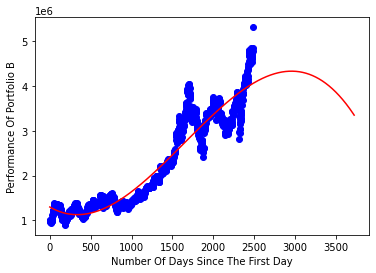

Coefficients for Portfolio C are [[ 0.00000000e+00 -5.09297036e+01  8.69624485e-01 -1.77588296e-04]]
Intercept for Portfolio C is [1179618.53525269]
R2-score for Portfolio C is 0.915824793548204


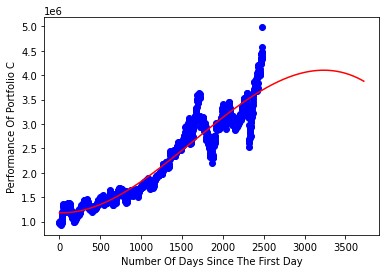

Coefficients for Portfolio D are [[ 0.00000000e+00 -4.42140551e+02  2.18535560e+00 -4.53838404e-04]]
Intercept for Portfolio D is [1243284.44974717]
R2-score for Portfolio D is 0.9189312750900556


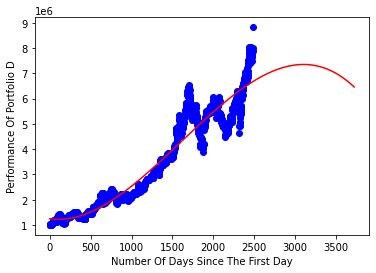

Coefficients for Portfolio E are [[ 0.00000000e+00 -9.45534514e+02  1.22084640e+00 -2.42467095e-04]]
Intercept for Portfolio E is [1277368.70485193]
R2-score for Portfolio E is 0.8779643935730377


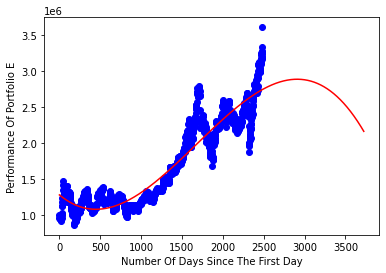

In [46]:
for i in range (0,4):
  train_x = np.asanyarray(train[['Number Of Days Since The First Day']])
  train_y = np.asanyarray(train[['Portfolio {}'.format(chr(66+i))]])
  test_x = np.asanyarray(test[['Number Of Days Since The First Day']])
  test_y = np.asanyarray(test[['Portfolio {}'.format(chr(66+i))]])
  poly = PolynomialFeatures(degree=3)
  train_x_poly = poly.fit_transform(train_x)
  clf = linear_model.LinearRegression()
  train_y_ = clf.fit(train_x_poly,train_y)
  test_x_poly = poly.fit_transform(test_x)
  test_y_ = clf.predict(test_x_poly)
  print('Coefficients for Portfolio {} are {}'.format(chr(66+i),clf.coef_))
  print('Intercept for Portfolio {} is {}'.format(chr(66+i),clf.intercept_))
  print("R2-score for Portfolio {} is {}".format(chr(66+i),r2_score(test_y,test_y_)))
  plt.scatter(train['Number Of Days Since The First Day'],train[['Portfolio {}'.format(chr(66+i))]],color='blue')
  XX = np.arange(0.0,3726,1) 
  yy = clf.intercept_[0]+clf.coef_[0][1]*XX+clf.coef_[0][2]*np.power(XX,2)+clf.coef_[0][3]*np.power(XX,3)
  plt.plot(XX,yy,'-r')
  plt.xlabel("Number Of Days Since The First Day")
  plt.ylabel("Performance Of Portfolio {}".format(chr(66+i)))
  plt.show()